In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [3]:
#загружаем датафрейм
aa_tests = pd.read_csv('/home/jupyter-a.kosheleva-14/aa_tests.csv', sep = ';')

In [4]:
aa_tests

,Unnamed: 0,uid,experimentVariant,version,purchase
0,1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0
...,...,...,...,...,...
127013,127014,d1f082ede77b17a99a9b0b240daf7bdf,0,v2.8.0,0
127014,127015,94f0d540830ccdc6b29c1938eea445cc,0,v2.8.0,0
127015,127016,709f74cf9721328e98be6f216e8a05a8,1,v2.9.0,0
127016,127017,1767ae3f8ffec269d9ed0ac0ede68d90,1,v2.8.0,0


In [5]:
#удаляем лишний столбец
aa_tests = aa_tests.drop('Unnamed: 0', 1)

In [7]:
aa_tests.dtypes

uid                  object
experimentVariant     int64
version              object
purchase              int64
dtype: object

In [8]:
aa_tests.isna().sum()

uid                  0
experimentVariant    0
version              0
purchase             0
dtype: int64

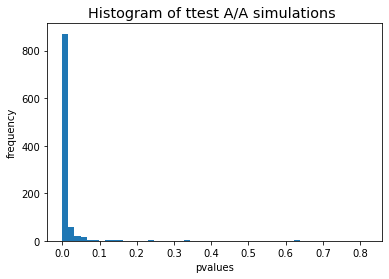

0.951

In [43]:
#скопируем код из приложенного ноутбука и вставляем свом данные для проверки в шаблон
n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = aa_tests[aa_tests.experimentVariant == 1]['purchase'].sample(n_s, replace = False).values
    s2 = aa_tests[aa_tests.experimentVariant == 0]['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

In [ ]:
#видим, что наш А/А тест не сходится и в 95% случаев мы получаем значимые различия, что-то не так. Надо проверить

In [48]:
#сравним конверсию в группах по столбцам experimentVariant - различия довольно сильные. разобьем поглубже 
aa_tests.groupby(['experimentVariant'], as_index = False) \
    .agg({'purchase' : 'mean'})

,experimentVariant,purchase
0,0,0.023945
1,1,0.053242


In [47]:
#сравним конверсию в группах по столбцу experimentVariant и version. Видим, что в 0 варианте эксперимента в версии v2.8.0 конверсия сильно ниже
aa_tests.groupby(['experimentVariant', 'version'], as_index = False) \
    .agg({'purchase' : 'mean'})

,experimentVariant,version,purchase
0,0,v2.8.0,0.000993
1,0,v2.9.0,0.074658
2,0,v3.7.4.0,0.059943
3,0,v3.8.0.0,0.057604
4,1,v2.8.0,0.045606
5,1,v2.9.0,0.071304
6,1,v3.7.4.0,0.063018
7,1,v3.8.0.0,0.062848


In [53]:
#проведем проверку на равенство средних в группах чтобы найти группы с p-value < 0.05 и исключить из нашего датафрейма
from scipy import stats

stats.ttest_ind(aa_tests[(aa_tests.experimentVariant == 1) & (aa_tests.version == 'v2.8.0')]['purchase'] , aa_tests[(aa_tests.experimentVariant == 0) & (aa_tests.version == 'v2.8.0')]['purchase'])

Ttest_indResult(statistic=42.963540840360324, pvalue=0.0)

In [54]:
stats.ttest_ind(aa_tests[(aa_tests.experimentVariant == 1) & (aa_tests.version == 'v2.9.0')]['purchase'] , aa_tests[(aa_tests.experimentVariant == 0) & (aa_tests.version == 'v2.9.0')]['purchase'])

Ttest_indResult(statistic=-0.9979597634962479, pvalue=0.31830895167207446)

In [55]:
stats.ttest_ind(aa_tests[(aa_tests.experimentVariant == 1) & (aa_tests.version == 'v3.7.4.0')]['purchase'] , aa_tests[(aa_tests.experimentVariant == 0) & (aa_tests.version == 'v3.7.4.0')]['purchase'])

Ttest_indResult(statistic=0.5874925850487471, pvalue=0.5568886771079735)

In [56]:
stats.ttest_ind(aa_tests[(aa_tests.experimentVariant == 1) & (aa_tests.version == 'v3.8.0.0')]['purchase'] , aa_tests[(aa_tests.experimentVariant == 0) & (aa_tests.version == 'v3.8.0.0')]['purchase'])

Ttest_indResult(statistic=1.1956188950206779, pvalue=0.23186933664059722)

In [ ]:
#по итогу убрать стоит группу с v2.8.0, это было и так вроде бы понятно из визуального анализа таблицы, но все равно стоило проверить

In [64]:
#удаляем
aa_tests = aa_tests.drop(aa_tests[aa_tests.version == 'v2.8.0'].index)

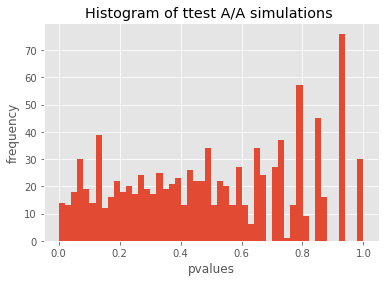

0.038

In [63]:
#перезапустим тест без нашей "бракованной" группы
n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = aa_tests[aa_tests.experimentVariant == 1]['purchase'].sample(n_s, replace = False).values
    s2 = aa_tests[aa_tests.experimentVariant == 0]['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

In [ ]:
#Ура, теперь мы получаем значимые различия всего в 4% случаев, поломка устранена!